In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# %matplotlib inline

from time import time
from operator import itemgetter
from datetime import datetime
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


# Functions

In [67]:
def finish():
    os.system("paplay /usr/share/sounds/gnome/default/alerts/drip.ogg")
    os.system("paplay /usr/share/sounds/gnome/default/alerts/glass.ogg")

# Load

In [2]:
kaggleTrain = pd.read_csv("kaggle/train.csv", header = 0)
kaggleTest = pd.read_csv("kaggle/test.csv", header = 0)

In [3]:
print "Kaggle Train count: " + str(len(kaggleTrain))
print "Kaggle Test count:  " + str(len(kaggleTest))

Kaggle Train count: 114321
Kaggle Test count:  114393


## Columns listing

In [73]:
#print train.schema.fields
columnsDict = {}
for col in kaggleTrain.columns:
    typeKey = str(kaggleTrain[col].dtype)
    colName = col
    
    if colName == 'ID':
        print "We have the ID columns, type: " + typeKey
        continue
    if colName == 'target':
        print "We have the target columns, type: " + typeKey
        continue
    
    if typeKey not in columnsDict:
        columnsDict[typeKey] = [colName]
    else:
        columnsDict[typeKey].append(colName)

print ""
for ct, cl in columnsDict.iteritems():
    print ct + " " + str(len(cl))

We have the ID columns, type: int64
We have the target columns, type: int64

object 19
int64 4
float64 108


# Split

In [74]:
train, test = train_test_split(kaggleTrain, test_size = 0.2)

# Prepare X and y

In [75]:
print len(columnsDict['float64']) +  len(columnsDict['int64'])

112


In [76]:
def prepareX(df):
    colsToAdd = columnsDict['float64'] + columnsDict['int64']
    
    dfX = df[colsToAdd]
    dfX = dfX.fillna(0)
    
    for col in colsToAdd:
        dfX[col+"_m"] = df[col]
    
    return dfX

In [77]:
def prepareY(df):   
    return df[["target"]].values.ravel()

In [78]:
X_train = prepareX(train)
y_train = prepareY(train)

In [79]:
X_test = prepareX(test)
y_test = prepareY(test)

In [80]:
colsMissingValues = train.isnull().sum()
print len(train.columns)
print len(colsMissingValues)

133
133


# Model

In [81]:
#.setNumTrees(150).setMaxDepth(6)
clf = RandomForestClassifier(n_estimators=150,
                             n_jobs=4,
                             max_depth=10,
                             criterion='gini') #  max_depth=7

In [135]:
clf = ExtraTreesClassifier(n_estimators=850, max_features=60, criterion='entropy', min_samples_split=4,
                            max_depth=40, min_samples_leaf=2, n_jobs=-1)     

In [ ]:
#clf.fit(X_train, y_train)

# Pipeline

In [136]:
imputer = Imputer(missing_values="NaN",
                  strategy="mean",
                  axis=0)

In [137]:
estimator = Pipeline([("imputer", imputer),
                      ("forest", clf)
                     ])

In [ ]:
estimator.fit(X_train, y_train)

In [92]:
evaluate(estimator, X_test, y_test, "Testing", "estimator")

Testing score: withImputer
0.761556964793
0.503607544381


## Features Analysis

In [86]:
def feature_analysis(model, X):
    importancePd = pd.DataFrame(model.feature_importances_, columns=["importance"])
    importancePd["feature"] = X.columns
    
    importancePd = importancePd.sort(['importance'], ascending=[0])
    importancePd = importancePd.set_index(['feature'])
    
    print importancePd.head(n=10)

    plt.figure();
    pylab.rcParams['figure.figsize'] = (30, 3)
    importancePd[:50].plot(kind='bar');
    importancePd[50:200].plot(kind='bar');
    plt.axhline(0, color='k')
    
    # Feature selection
    
    

         importance
feature            
v50_m      0.197865
v50        0.163362
v10_m      0.056644
v129       0.044978
v10        0.040775
v62_m      0.038223
v129_m     0.037737
v14_m      0.031863
v12        0.030988
v12_m      0.027510


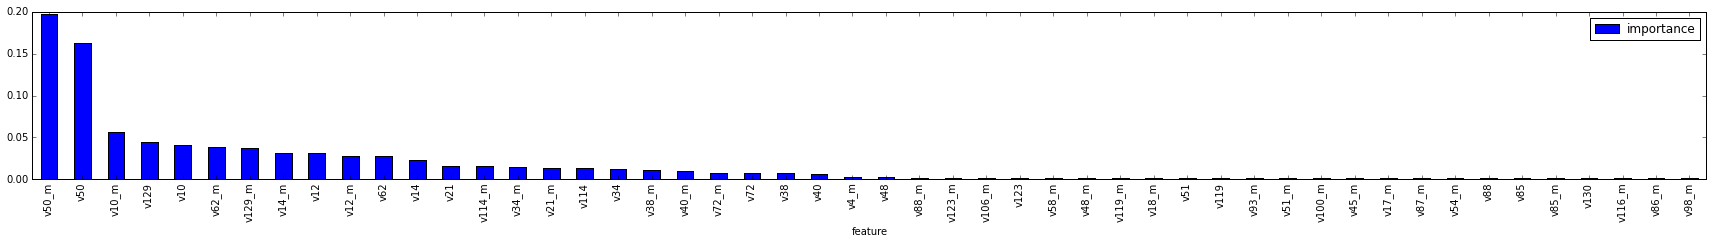

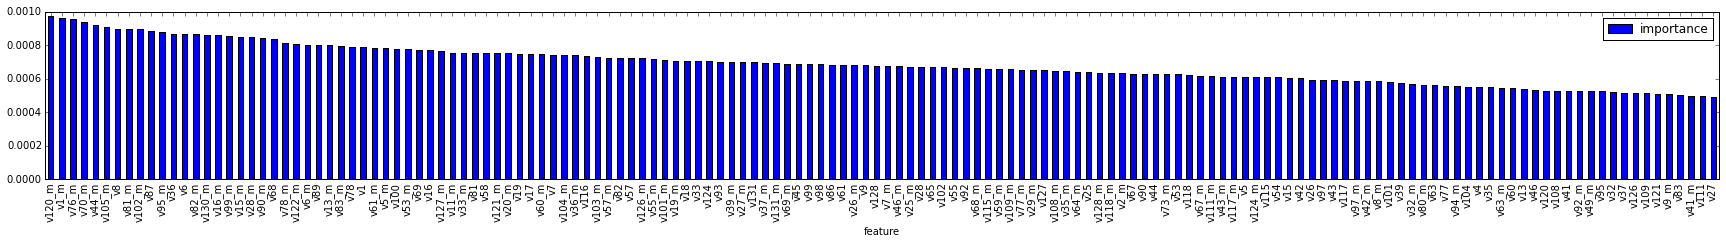

In [87]:
feature_analysis(clf, X_train)

## Score

In [119]:
bestLogloss = 0.503616393572
def evaluate(model, X, y, string, more = ""):
    title = string + " score: " + more
    score = model.score(X, y)
    scoreLogloss = log_loss(y, model.predict_proba(X))
    
    currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    modelExplaination = clf.get_params()
    
    logline = str(score) + ";" + str(scoreLogloss) + ";" + currentDate + ";" + str(modelExplaination) + ";" + more
    
    with open("evaluate"+string+".log", "a") as myfile:
        myfile.write(logline+"\n")
    
    print title
    print score
    print str(scoreLogloss)  + " compare to best score: " + str(scoreLogloss-bestLogloss) 

In [95]:
evaluate(estimator, X_train, y_train, "Training", "estimator")

Training score: 
0.761131035689
0.496644149422


In [96]:
evaluate(estimator, X_test, y_test, "Testing", "estimator")

Testing score: 
0.761556964793
0.503607544381


# Grid search

In [127]:
# Utility function to report best scores
def report(grid_scores, n_top=3, save=False):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if save:
            currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            logline = str("{0}".format(i + 1)) + ";" + "{0:.5f};{1:.5f}".format(score.mean_validation_score,np.std(score.cv_validation_scores)) + ";" + currentDate + ";" + "{0}".format(score.parameters)
            with open("gridSearch.log", "a") as myfile:
                myfile.write(logline+"\n")

In [114]:
sqrt(len(X_train.columns))

14.966629547095765

In [115]:
# specify parameters and distributions to sample from
modelName = "forest__"
param_dist = {modelName+"max_depth": [None],          # Default -> None | If Nonen then nodes are expanded until min_samples_split (Ignored if max_leaf_nodes is not None.)
              modelName+"max_features": [16],#sp_randint(14, 24),      # Default -> sqrt(n_features) ~14
              modelName+"min_samples_split": sp_randint(1, 4), # Default -> 2 (useless if mex_depth not None)
              modelName+"min_samples_leaf": sp_randint(5, 13),  # Default -> 1
              modelName+"bootstrap": [False]              # Default -> True
              #modelName+"criterion": ["gini", "entropy"] # gini
             }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(estimator, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring="log_loss")

In [116]:
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)
finish()

RandomizedSearchCV took 2990.35 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.493 (std: 0.001)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 16, 'forest__min_samples_leaf': 9, 'forest__max_depth': None, 'forest__min_samples_split': 3}

Model with rank: 2
Mean validation score: -0.494 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 16, 'forest__min_samples_leaf': 8, 'forest__max_depth': None, 'forest__min_samples_split': 1}

Model with rank: 3
Mean validation score: -0.496 (std: 0.001)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 17, 'forest__min_samples_leaf': 1, 'forest__max_depth': 10, 'forest__min_samples_split': 1}



In [128]:
report(random_search.grid_scores_, 20, True)

Model with rank: 1
Mean validation score: -0.493 (std: 0.001)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 16, 'forest__min_samples_leaf': 9, 'forest__max_depth': None, 'forest__min_samples_split': 3}

Model with rank: 2
Mean validation score: -0.494 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 16, 'forest__min_samples_leaf': 8, 'forest__max_depth': None, 'forest__min_samples_split': 1}

Model with rank: 3
Mean validation score: -0.496 (std: 0.001)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 17, 'forest__min_samples_leaf': 1, 'forest__max_depth': 10, 'forest__min_samples_split': 1}

Model with rank: 4
Mean validation score: -0.496 (std: 0.001)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 16, 'forest__min_samples_leaf': 2, 'forest__max_depth': 10, 'forest__min_samples_split': 3}

Model with rank: 5
Mean validation score: -0.496 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_

In [118]:
evaluate(random_search.best_estimator_, X_test, y_test, "Testing", "GridSearchBest")

Testing score: GridSearch
0.77327793571
0.488858313755


# Save

In [129]:
modelToSave = estimator
modelToSave = random_search.best_estimator_

In [130]:
X_kaggleTest = prepareX(kaggleTest)

In [131]:
predic = modelToSave.predict_proba(X_kaggleTest)[:,1] # extract 2nd column for X=1

In [132]:
predicPd = pd.DataFrame(predic)
predicPd = predicPd.rename(columns={0: 'PredictedProb'})
predicPd['ID'] = kaggleTest[['ID']]
predicPd = predicPd[['ID', 'PredictedProb']]

In [133]:
predicPd.to_csv("results/pythonpure/results.csv", index = False)